In [2]:
import sys 
sys.path.append('../Data_storage/')
sys.path.append('../Code_Base')

In [3]:
import os

In [4]:
from essential_imports import *


import pandas as pd
import numpy as np
import matplotlib as plt
import pandas_profiling
import warnings



In [5]:
from coin_information import *

In [6]:
from statsmodels.tsa.stattools import adfuller 

In [7]:
from matplotlib.pylab import rcParams 

In [8]:
warnings.filterwarnings('ignore')

## ML DS modules

In [9]:
from statsmodels.tsa.arima_model import ARIMA

In [10]:
ETH = []
for myf in open('../Data_storage/ETH_5min_Freq.txt'):
    ETH.append(myf.replace('\n',''))

In [11]:
ETH_Data = []
for E in ETH:
    E_Temp = pd.read_csv('../Data_storage/Coin_Data_5min/{0}.csv'.format(E))
    ETH_Data.append(E_Temp)

In [12]:
ETH_Data = pd.concat(ETH_Data)

In [13]:
ETH_Data['datetime_real'] = ETH_Data['date'].apply(lambda x: datetime.fromtimestamp(x))

In [14]:
ETH_Data = ETH_Data[ETH_Data['date'] != 0]

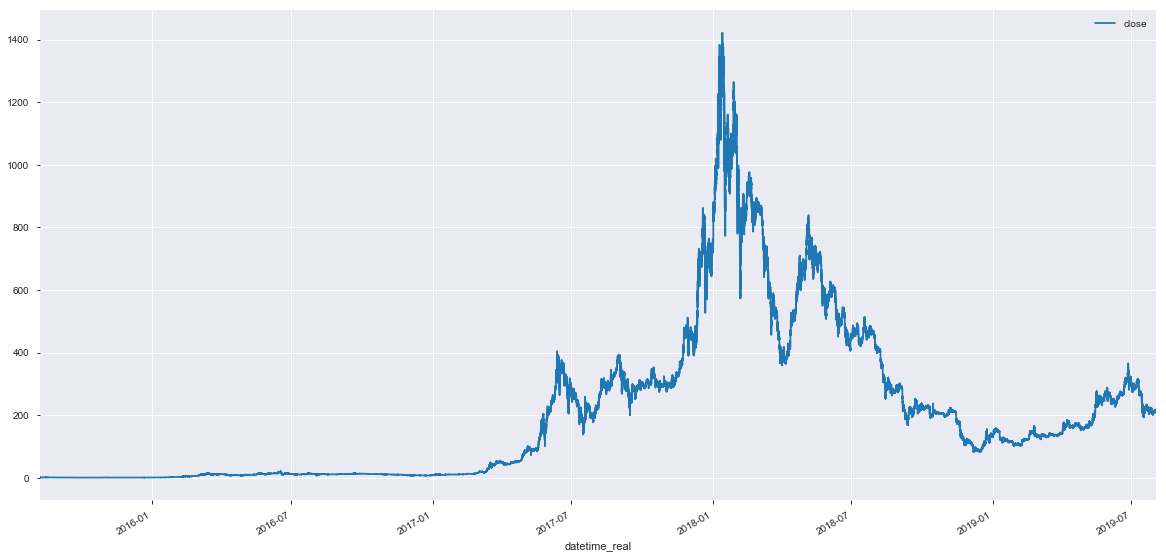

In [15]:
ETH_Data[['close','datetime_real']].set_index('datetime_real').plot(figsize= (20,10))

In [16]:
ETH_Data = ETH_Data.drop(columns = 'Unnamed: 0').drop_duplicates()

## Swing Analysis 

In [77]:
swing_ETH = ETH_Data[['high','close','low','datetime_real','volume']]#.groupby(pd.Grouper(key='datetime_real', freq= 'D'))

In [78]:
#swing_ETH.groupby(pd.Grouper(key = 'datetime_real', freq= 'H')

In [79]:
rolling_12Hour = 7 # which is 35minutes, much better for day swing, old was 5*12*12 

In [80]:
swing_ETH['close_rolling_{0}'.format(rolling_12Hour)] = swing_ETH['close'].rolling(window = rolling_12Hour).mean()

In [86]:
swing_ETH['from_RA'] = swing_ETH['close'] - swing_ETH['close_rolling_7']

In [91]:
swing_ETH['Percent_Difference'] = swing_ETH['from_RA']/swing_ETH['close_rolling_7'] * 100

In [92]:
swing_ETH['Percent_Difference_RA'] = swing_ETH['Percent_Difference'].rolling(window = 720).mean()

In [93]:
#swing_ETH[(swing_ETH['datetime_real'] >= '2017-01-01')].set_index('datetime_real')[['Percent_Difference_RA']].plot(figsize = (20,20))

In [94]:
swing_ETH['Bull_Bear'] = swing_ETH['Percent_Difference'].apply(lambda x : 'Bull' if x > 2 else 'Bear' if x < -2 else None)

In [95]:
swing_ETH['Bull_Bear'] = swing_ETH['Bull_Bear'].fillna(method = 'ffill')

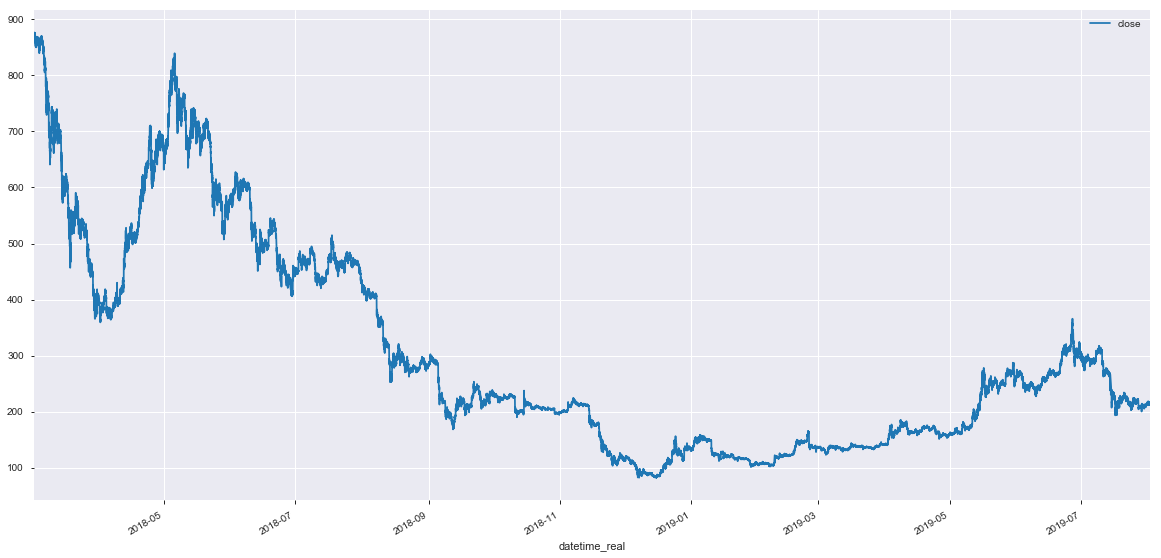

In [96]:
swing_ETH[swing_ETH['datetime_real'] > '2018-03-02'].set_index('datetime_real')[['close']].plot(figsize = (20,10))

In [97]:
swing_below_4percent = swing_ETH[(swing_ETH['Percent_Difference'] < -4) & (swing_ETH['volume'] > 2) ][['datetime_real']]

In [98]:
swing_below_4percent['Buy'] = 1

In [99]:
len(swing_ETH[(swing_ETH['Percent_Difference'] > 2) & (swing_ETH['volume'] > 2) ])

2912

In [100]:
len(swing_ETH)

418719

In [101]:
94274/418719

0.22514860801635464

10% time it dips below 2% of RA

In [102]:
swing_ETH = swing_ETH.merge(swing_below_4percent, on = 'datetime_real', how = 'left')

In [103]:
swing_ETH['Buy'] = swing_ETH['Buy'].fillna(0)

In [104]:
swing_ETH['Buy_shift'] = swing_ETH['Buy'].shift(-1)

In [105]:
swing_ETH['Group'] = swing_ETH['Buy'] - swing_ETH['Buy_shift']

In [106]:
Zero_to_One = swing_ETH[swing_ETH['Group'] == -1][['datetime_real','Group']]

In [107]:
Zero_to_One['Zero_to_One'] = Zero_to_One['Group'].cumsum()

In [108]:
One_to_Zero = swing_ETH[swing_ETH['Group'] == 1][['datetime_real','Group']]

In [109]:
One_to_Zero['One_to_Zero'] = One_to_Zero['Group'].cumsum()

In [110]:
Grouping  = pd.concat([One_to_Zero,Zero_to_One]).sort_values(by = 'datetime_real')

In [111]:
Grouping['New_Group'] = Grouping['Zero_to_One'].fillna(Grouping['One_to_Zero'])

In [112]:
swing_ETH = swing_ETH.merge(Grouping[['datetime_real','New_Group']], on = 'datetime_real', how= 'outer')

In [113]:
swing_ETH['New_Group_2'] = swing_ETH['New_Group'].fillna(method ='bfill')

In [114]:
highests =  swing_ETH.groupby(['New_Group_2'],as_index=False).agg({'high':'max'})

In [115]:
swing_ETH[swing_ETH['New_Group_2'] == -6927.0]

,high,close,low,datetime_real,volume,close_rolling_7,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2


In [116]:
Highest_by_Group = swing_ETH.loc[swing_ETH.groupby(['New_Group_2'])['high'].idxmax()] # highest value within next groups

In [117]:
swing_ETH.head(1)

,high,close,low,datetime_real,volume,close_rolling_7,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2
0,1.75,1.75,1.61,2015-08-08 07:15:00,75.15,NaN,NaN,NaN,NaN,None,0.0,0.0,0.0,NaN,-1.0


In [118]:
swing_ETH.tail()

,high,close,low,datetime_real,volume,close_rolling_7,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2
418714,216.823109,216.823109,216.823109,2019-08-02 00:20:00,32.752293,216.826507,-0.003397,-0.001567,0.016133,Bull,0.0,0.0,0.0,NaN,NaN
418715,216.812109,216.812109,216.812109,2019-08-02 00:25:00,465.016979,216.829519,-0.017410,-0.008029,0.016086,Bull,0.0,0.0,0.0,NaN,NaN
418716,216.812109,216.688005,216.688005,2019-08-02 00:30:00,217.376095,216.814803,-0.126798,-0.058482,0.015983,Bull,0.0,0.0,0.0,NaN,NaN
418717,216.688005,216.534003,216.534003,2019-08-02 00:35:00,701.594161,216.784836,-0.250833,-0.115706,0.015534,Bull,0.0,0.0,0.0,NaN,NaN
418718,216.691436,216.691436,216.668446,2019-08-02 00:40:00,571.125481,216.777360,-0.085924,-0.039637,0.015207,Bull,0.0,NaN,NaN,NaN,NaN


In [119]:
HG_merge = Highest_by_Group[['New_Group_2','high']].rename(columns = {'high' :  'high_Group'})

In [120]:
swing_ETH = swing_ETH.merge(HG_merge, on = 'New_Group_2', how ='outer')

In [121]:
swing_ETH[(swing_ETH['datetime_real'] > '2019-07-10') & 
          (swing_ETH['datetime_real'] < '2019-07-11')].tail()

,high,close,low,datetime_real,volume,close_rolling_7,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2,high_Group
412369,289.480001,289.480001,289.089461,2019-07-10 23:35:00,2641.301254,288.289343,1.190658,0.413008,-0.025984,Bear,0.0,0.0,0.0,NaN,-407.0,346.529991
412370,289.480001,288.848341,288.848341,2019-07-10 23:40:00,3399.110970,288.396773,0.451568,0.156579,-0.026018,Bear,0.0,0.0,0.0,NaN,-407.0,346.529991
412371,290.303400,290.303400,289.513200,2019-07-10 23:45:00,4319.641340,288.782653,1.520747,0.526606,-0.025536,Bear,0.0,0.0,0.0,NaN,-407.0,346.529991
412372,289.891486,289.516694,289.448491,2019-07-10 23:50:00,2551.482324,289.046130,0.470564,0.162799,-0.025279,Bear,0.0,0.0,0.0,NaN,-407.0,346.529991
412373,289.677265,289.485278,289.485278,2019-07-10 23:55:00,3111.258236,289.202385,0.282893,0.097818,-0.025138,Bear,0.0,0.0,0.0,NaN,-407.0,346.529991


In [142]:
table[30:]['high'].max()

246.6232091

In [137]:
246.000000 * 1.04

255.84

In [136]:
table[table['Buy'] == 1]

,high,close,low,datetime_real,volume,close_rolling_7,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2,high_Group
413368,262.947368,246.000000,246.000000,2019-07-14 10:50:00,347717.233455,261.987463,-15.987463,-6.102377,-0.015358,Bear,1.0,1.0,0.0,NaN,408.0,262.947368
413369,246.000000,242.096800,240.660000,2019-07-14 10:55:00,125033.425080,258.669129,-16.572329,-6.406767,-0.024627,Bear,1.0,1.0,0.0,NaN,408.0,262.947368
413370,244.611892,243.575198,241.766284,2019-07-14 11:00:00,55573.081218,255.560347,-11.985149,-4.689753,-0.031393,Bear,1.0,0.0,1.0,408.0,408.0,262.947368


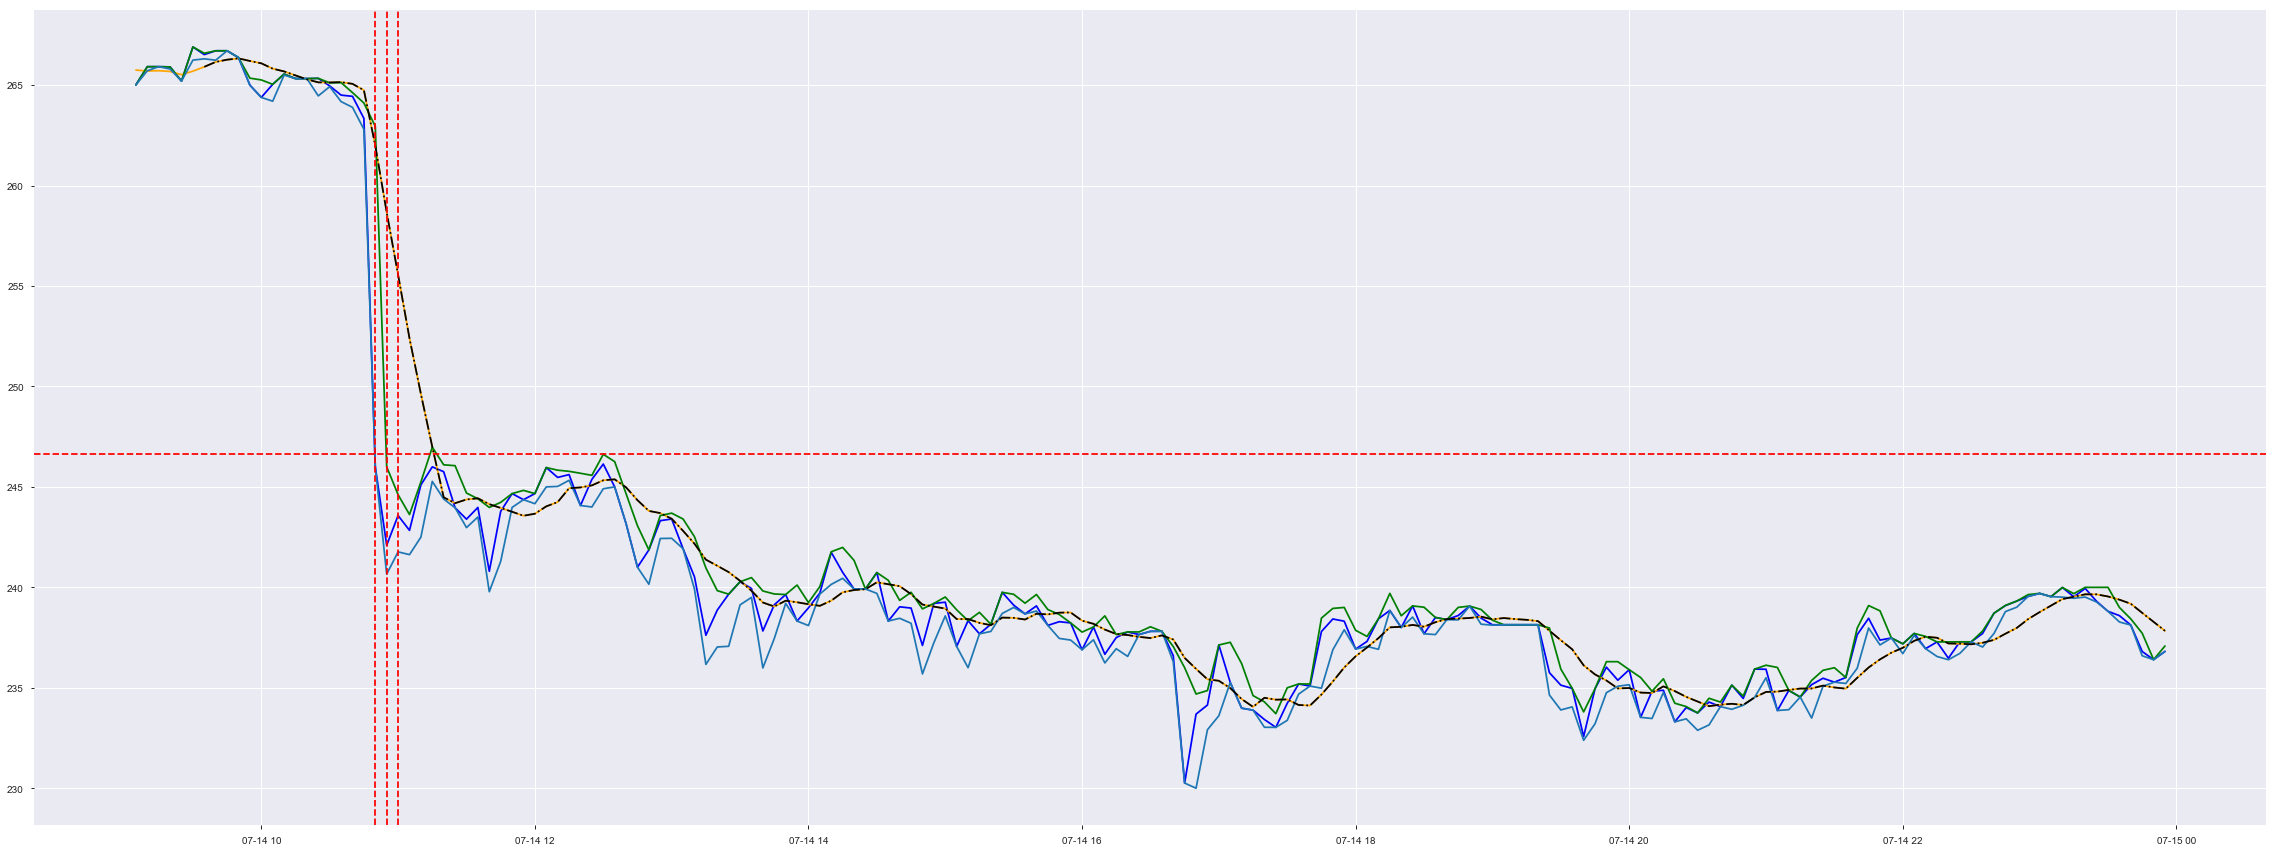

In [145]:


table = swing_ETH[-8000:]

table = swing_ETH[(swing_ETH['datetime_real'] > '2019-07-14 09:00:00') & 
          (swing_ETH['datetime_real'] < '2019-07-15')]
           
x = table['datetime_real']


y_close           = table['close']
y_high            = table['high']
y_low             = table['low']
y_close_rollling  = table['close_rolling_7']

fig, ax = plt.subplots(figsize = (40,15))

line1 = ax.plot(x, y_close, color = 'blue')
line1 = ax.plot(x, y_close_rollling, color = 'orange')

line1 = ax.plot(x, y_high, color = 'green' )
line1 = ax.plot(x, y_low)

line1 = ax.plot(x, y_close.rolling(window = 7).mean(), color = 'k' , linestyle='-.')


plt.axhline(y= 246.6232091, color='r', linestyle='--')
    
for vert in list(table[table['Buy'] == 1]['datetime_real']):
    plt.axvline(x=vert, color='r', linestyle='--')
    
    
# for hourline in table.groupby(pd.Grouper(key = 'datetime_real', freq= 'D'))[['high']].first().index:
#     plt.axvline(x=hourline, color='green', linestyle='-.')


plt.show()

In [289]:
swing_ETH[900:]

,high,close,low,datetime_real,volume,close_rolling_720,from_RA,Percent_Difference,Percent_Difference_RA,Bull_Bear,Buy,Buy_shift,Group,New_Group,New_Group_2,high_Group
900,0.660000,0.660000,0.660000,2015-08-11 10:15:00,0.000000,1.314694,-0.654694,-49.798221,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
901,0.660000,0.660000,0.660000,2015-08-11 10:20:00,0.000000,1.313667,-0.653667,-49.758944,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
902,0.660000,0.660000,0.660000,2015-08-11 10:25:00,0.000000,1.312639,-0.652639,-49.719606,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
903,0.660000,0.660000,0.660000,2015-08-11 10:30:00,0.000000,1.311611,-0.651611,-49.680206,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
904,0.660000,0.660000,0.660000,2015-08-11 10:35:00,0.000000,1.310583,-0.650583,-49.640745,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
905,0.660000,0.660000,0.660000,2015-08-11 10:40:00,0.000000,1.309556,-0.649556,-49.601221,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
906,0.660000,0.660000,0.660000,2015-08-11 10:45:00,0.000000,1.308528,-0.648528,-49.561636,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
907,0.660000,0.660000,0.660000,2015-08-11 10:50:00,0.000000,1.307500,-0.647500,-49.521988,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
908,0.660000,0.660000,0.660000,2015-08-11 10:55:00,0.000000,1.306472,-0.646472,-49.482278,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85
909,0.660000,0.660000,0.660000,2015-08-11 11:00:00,0.000000,1.305444,-0.645444,-49.442505,NaN,Bear,0.0,0.0,0.0,NaN,-1.0,1.85


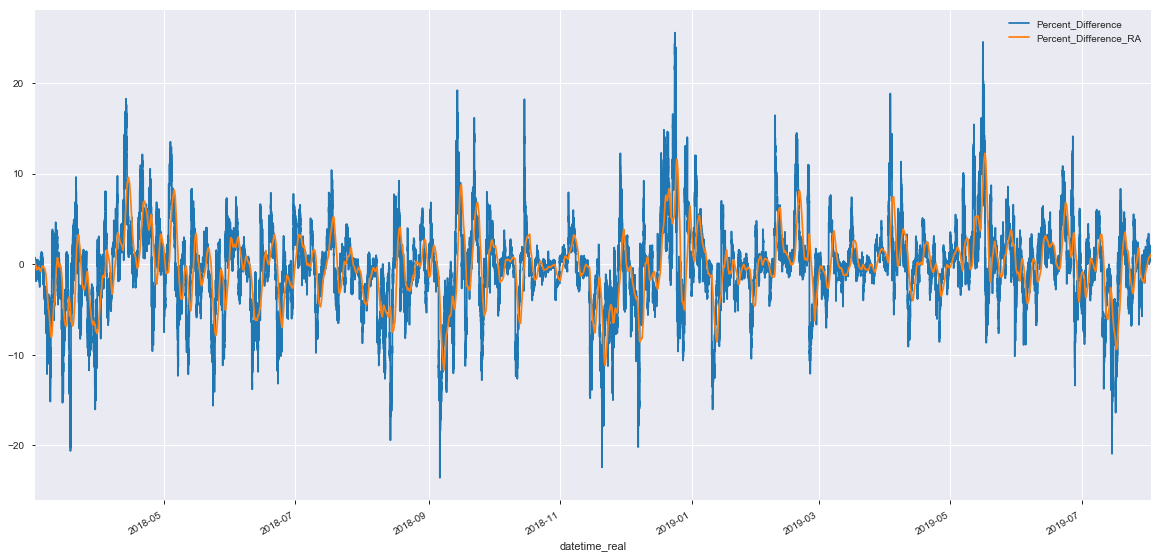

In [269]:
swing_ETH[swing_ETH['datetime_real'] > '2018-03-02'].set_index('datetime_real')[['Percent_Difference','Percent_Difference_RA']].plot(figsize = (20,10))

In [130]:
BTC = []
for myf in open('../Data_storage/BTC_30min_Freq.txt'):
    BTC.append(myf.replace('\n',''))

In [131]:
BTC_Data = []
for E in BTC:
    coin_Temp = pd.read_csv('../Data_storage/Coin_Data_30min/{0}.csv'.format(E))
    BTC_Data.append(coin_Temp)

In [132]:
BTC_Data = pd.concat(BTC_Data)

In [133]:
BTC_Data['datetime_real'] = BTC_Data['date'].apply(lambda x: datetime.fromtimestamp(x))

In [134]:
BTC_Data = BTC_Data[BTC_Data['date'] != 0]

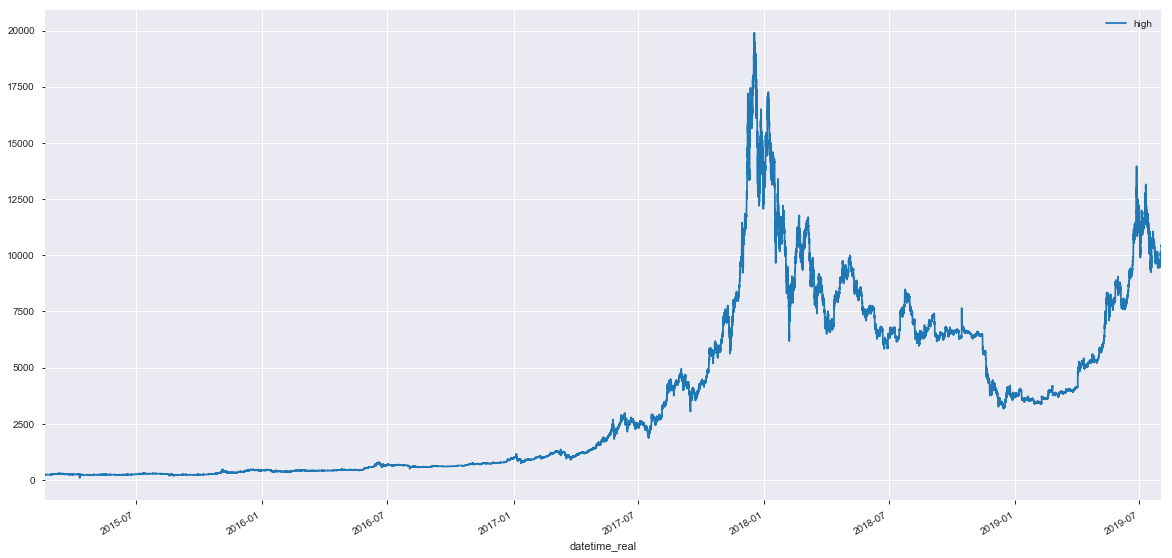

In [135]:
BTC_Data[['high','datetime_real']].set_index('datetime_real').plot(figsize= (20,10))

In [136]:
BTC_Data = BTC_Data.drop(columns = 'Unnamed: 0')

In [137]:
BTC_Data= BTC_Data.drop_duplicates()

In [138]:
pandas_profiling.ProfileReport(BTC_Data)

KeyboardInterrupt: 

In [140]:
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(48).mean()# pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = timeseries.rolling(48).std()# pd.rolling_std(timeseries, window=24)
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [141]:
BTC_Data.tail()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,datetime_real
2587,10411.843688,1564695000,10412.543688,10363.761065,10371.040000,7.569329,78616.453010,10386.185539,2019-08-01 22:30:00
2588,10369.303684,1564696800,10425.018269,10362.000000,10410.000000,7.037109,73281.852989,10413.630111,2019-08-01 23:00:00
2589,10365.000000,1564698600,10378.070000,10362.000000,10375.000000,0.635737,6592.862424,10370.417598,2019-08-01 23:30:00
2590,10393.371188,1564700400,10417.000000,10363.500000,10365.000000,16.803258,174840.979376,10405.183378,2019-08-02 00:00:00
2591,10390.600000,1564702200,10391.801814,10365.700000,10391.365263,2.258918,23429.361882,10371.940103,2019-08-02 00:30:00


In [142]:
rcParams['figure.figsize'] = 20,10

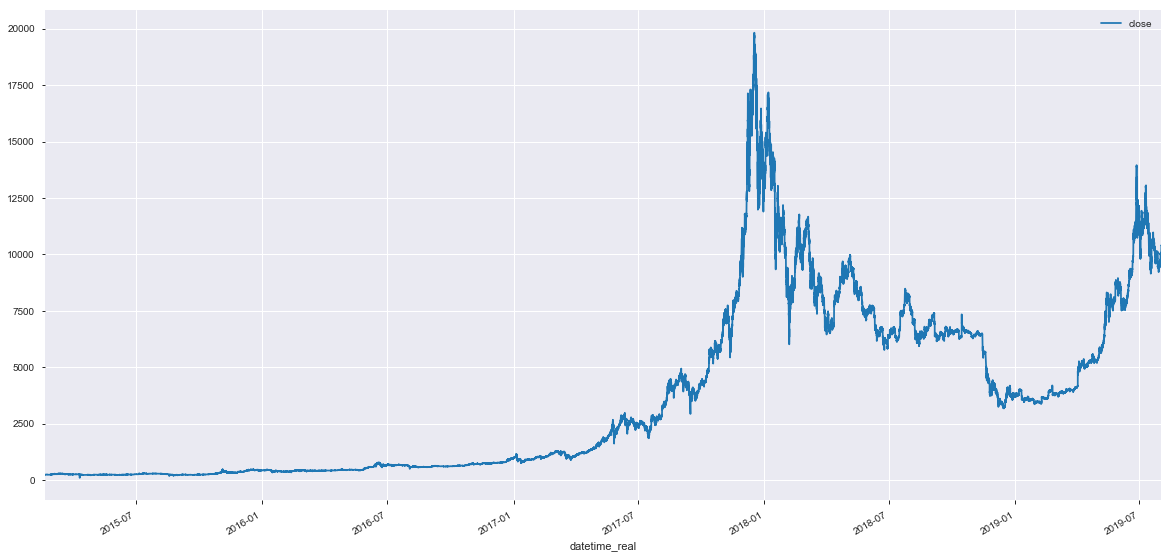

In [143]:
BTC_Data[['close','datetime_real']].set_index('datetime_real').plot()

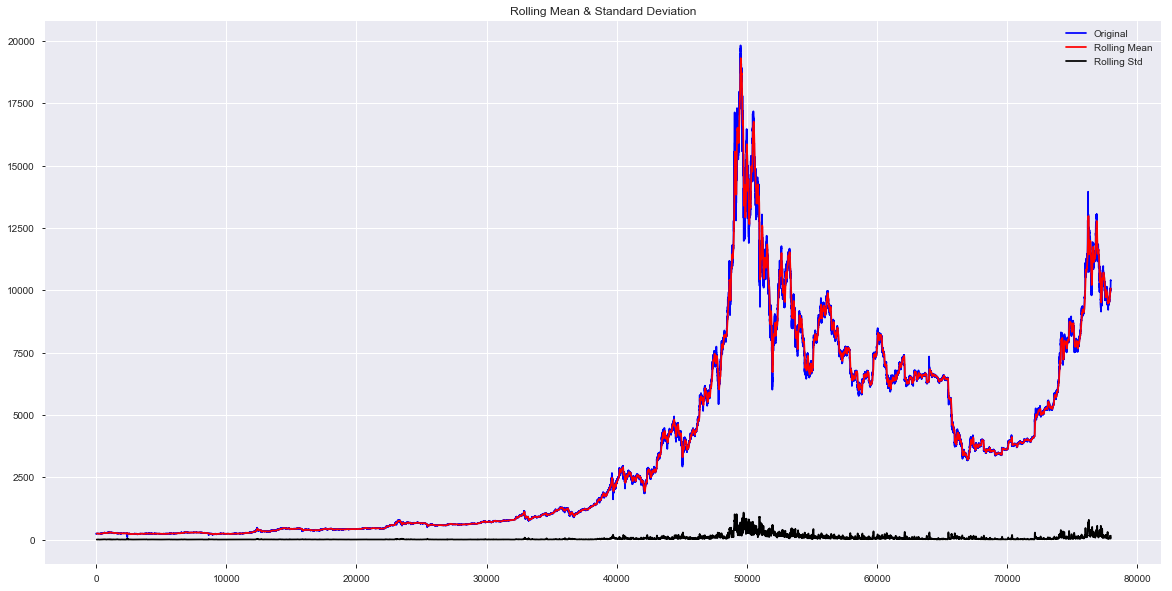

Results of Dickey-Fuller Test:
Test Statistic                    -1.034633
p-value                            0.740424
#Lags Used                        64.000000
Number of Observations Used    77885.000000
Critical Value (1%)               -3.430434
Critical Value (5%)               -2.861577
Critical Value (10%)              -2.566790
dtype: float64


In [180]:
#test_stationarity(train_original['Count'])
test_stationarity(BTC_Data['close'].reset_index()['close'])

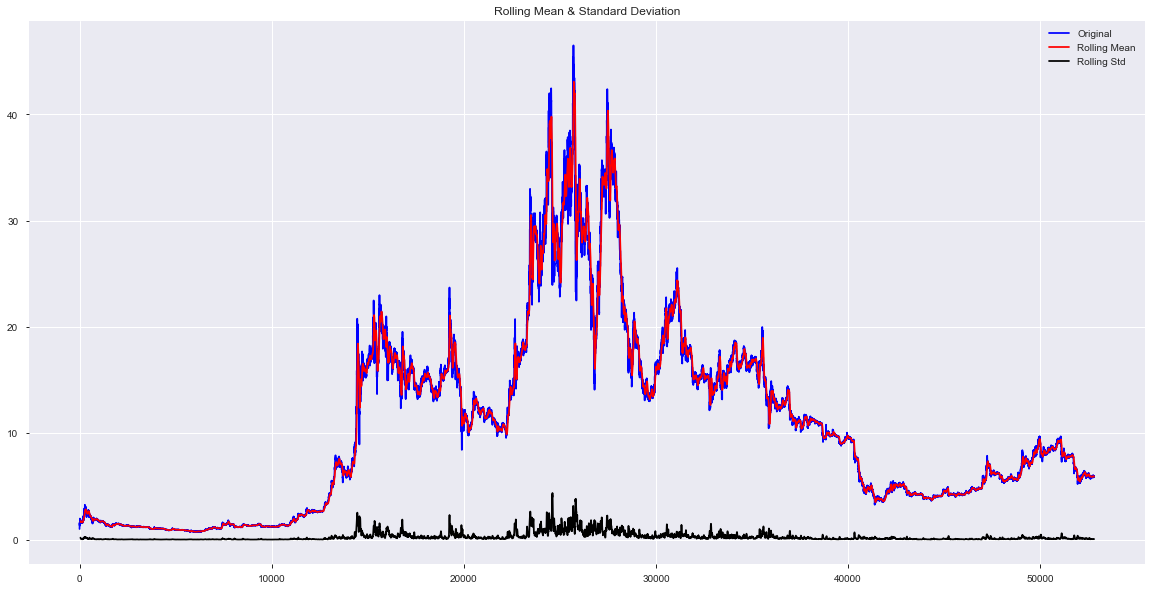

Results of Dickey-Fuller Test:
Test Statistic                    -2.265791
p-value                            0.183238
#Lags Used                        58.000000
Number of Observations Used    52742.000000
Critical Value (1%)               -3.430474
Critical Value (5%)               -2.861595
Critical Value (10%)              -2.566799
dtype: float64


In [181]:
#test_stationarity(train_original['Count'])
test_stationarity(ETH_Data['close'].reset_index()['close'])